## User guide of the models comparison using bosk

You may want to compare different models in `bosk`: for example, several `bosk` deep forests with the different layers number and some models outside of the framework. For this purposes the `bosk.comparison` subpackage was developed.

Let's define some models:

In [1]:
from bosk.block.zoo.models.classification import RFCBlock
from bosk.comparison.cross_val import CVComparator
from bosk.comparison.base import BaseForeignModel
from bosk.comparison.metric import MetricWrapper
from bosk.data import CPUData, BaseData
from bosk.executor.topological import TopologicalExecutor
from bosk.painter.graphviz import GraphvizPainter
from bosk.painter.topological import TopologicalPainter
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from bosk.stages import Stage
from catboost import CatBoostClassifier
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import torch
from typing import Dict
from torch.utils.data import TensorDataset, DataLoader
from joblib import hash
from IPython.display import Image

In [2]:
n_trees = 20

# we will make some similar bosk pipelines

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_trees)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_trees)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_trees)(X=concat_1, y=y)
pipeline_1 = b.build({'X': X, 'y': y}, {'output': rf_2})

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_trees)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_trees)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_trees)(X=concat_1, y=y)
stack = b.Stack(['rf_2_1', 'rf_2_2'], axis=2)(rf_2_1=rf_2, rf_2_2=rf_2)
av = b.Average(axis=2)(X=stack)
pipeline_2 = b.build({'X': X, 'y': y}, {'output': av})

b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_trees)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_trees)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_trees)(X=concat_1, y=y)
et_2 = b.ETC(n_estimators=n_trees)(X=concat_1, y=y)
concat_2 = b.Concat(['rf_2', 'et_2', 'X'])(X=X, rf_2=rf_2, et_2=et_2)
et_3 = b.ETC(n_estimators=n_trees)(X=concat_2, y=y)
pipeline_3 = b.build({'X': X, 'y': y}, {'output': et_3})

pipeline_list = [pipeline_1, pipeline_2, pipeline_3]

To use models, written beneath the bosk, you have to write your own adapter class that inherits the `BaseForeignModel` interface. This interface requires the model to handle bosk data dictionaries and implement the `set_random_state` method as a comparison experiment should be reproducible. 

Let's define two such models:

In [3]:
class CatBoostModel(BaseForeignModel):
    def __init__(self) -> None:
        super().__init__()
        self.grad_boost = CatBoostClassifier(30, verbose=0)

    def fit(self, data: Dict[str, BaseData]) -> None:
        self.grad_boost.fit(
            data['X'].to_cpu().data,
            data['y'].to_cpu().data
        )

    def predict(self, data: Dict[str, BaseData]) -> Dict[str, BaseData]:
        return {'output': CPUData(
                self.grad_boost.predict_proba(data['X'].to_cpu().data)
                )}

    def set_random_state(self, random_state: int) -> None:
        self.grad_boost.random_state = random_state


class NeuralNetwork(torch.nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.device = torch.device('cuda')
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(dim, dim * 10),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 10, dim),
            torch.nn.Tanh(),
            torch.nn.Linear(dim, 1),
            torch.nn.Sigmoid()
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.nn.parameters(), 0.0005)
        self.batch_size = 64
        self.epochs_num = 500
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def _get_tensor(self, x: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(x.astype(np.float32)).to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proba = self.nn(x)
        return torch.concat((1 - proba, proba), dim=-1)

    def transform(self, x: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            x = self._get_tensor(x)
            return self(x).cpu().numpy()

    def fit(self, x: np.ndarray, y: np.ndarray) -> 'NeuralNetwork':
        x_tens = self._get_tensor(x)
        y_tens = self._get_tensor(y).long()
        dataset = TensorDataset(x_tens, y_tens)
        data_loader = DataLoader(dataset, self.batch_size, True)
        self.train()
        for _ in range(self.epochs_num):
            for x, y in data_loader:
                self.optimizer.zero_grad()
                pred = self(x)
                loss = self.loss_fn(pred, y)
                loss.backward()
                self.optimizer.step()
        return self


class NNModel(BaseForeignModel):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.nn = NeuralNetwork(dim)

    def fit(self, data: Dict[str, BaseData]) -> None:
        return self.nn.fit(
            data['X'].to_cpu().data,
            data['y'].to_cpu().data
        )

    def predict(self, data: Dict[str, BaseData]) -> Dict[str, BaseData]:
        return {'output': CPUData(
                self.nn.transform(data['X'].to_cpu().data)
                )}

    def set_random_state(self, random_state: int) -> None:
        torch.manual_seed(random_state)

        def init_weights(obj):
            if isinstance(obj, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(obj.weight)
        with torch.no_grad():
            self.nn.apply(init_weights)

Also, we need to redefine sklearn metrics a little bit and, just as above, create adapters to handle bosk data dictionaries (in this example we will do it later). Fortunately, in case of simple metrics we can easily use the ready wrapper class `MetricWrapper`.

In [4]:
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, np.int_(y_pred[:, 1]))


def roc_auc(y_true, y_pred):
    return roc_auc_score(y_true, np.int_(y_pred[:, 1]))

Now we can talk about `CVComparator` class. It performes various models comparison via cross-validation algorithm. The cross validation scheme is chosen by the user and should have the sklearn `BaseCrossValidator` interface. 

The comparator will try to optimize the `bosk` pipelines passed in. It means that the comparator will try to find the common part of all pipelines and run this part only once. This will reduce the comparison time. The important detail: common blocks are found using the `joblib.hash` function and it can produce different md5 hashes for the semantically identical blocks:

In [5]:
block_1 = RFCBlock() # 100 trees by default
block_2 = RFCBlock(n_estimators=100) # also 100 trees
# hashes of those blocks will be different
print('- Whether hashes are the same?')
print('-', hash(block_1) == hash(block_2))

- Whether hashes are the same?
- False


Therefore before the comparison for all the blocks across the pipelines the same random seed is set. If for some reason the optimization algorithm ruins your model, you can turn it off by passing `False` value to the `f_optimize_pipelines` argument. In this case only `set_random_state` method will be used for the pipelines before the comparison and the `copy.deepcopy` during the one.

Let's draw the changed pipelines to see what's happening inside of `BaseComparator`

In [6]:
# firstly we will define the CV strategy
# for creating the CVComparator object
random_seed = 42
cv_strat = KFold(n_splits=3, shuffle=True, random_state=random_seed)
# if you don't want to compare foreign models
# or bosk pipelines, just pass None to the
# corresponding argument
comparator = CVComparator(
    pipelines=pipeline_list,
    foreign_models=[CatBoostModel(), NNModel(dim=2)],
    cv_strat=cv_strat,
    get_blocks_times=True,
    f_optimize_pipelines=True,
    random_state=random_seed
)

Found common part of the three pipelines

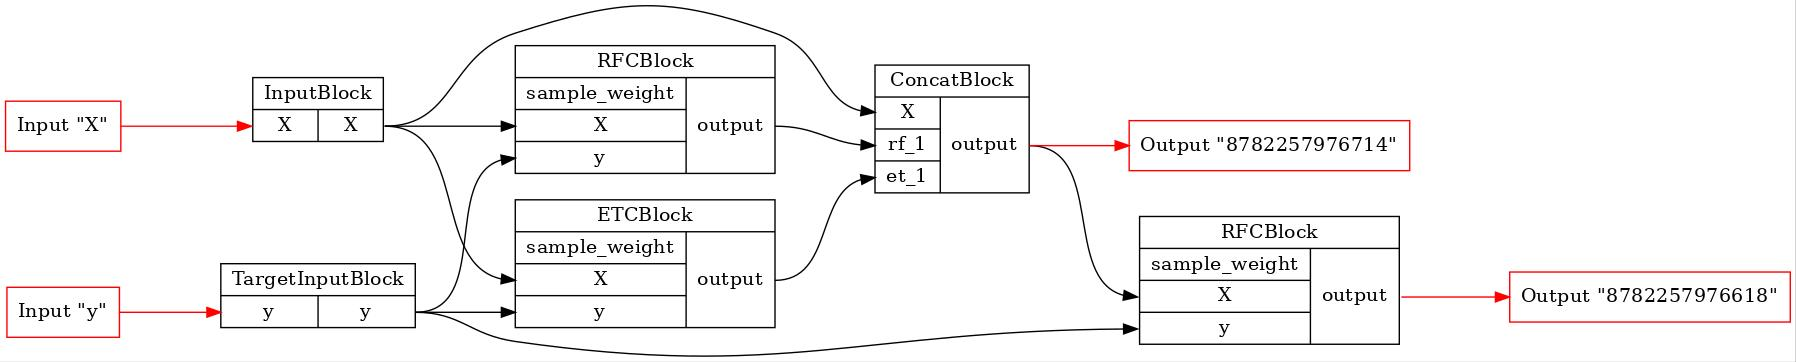

In [7]:
GraphvizPainter(figure_dpi=100).from_pipeline(comparator._common_pipeline).render('pipeline.jpeg')
display(Image('pipeline.jpeg'))

And let's see the first and the last pipelines on the FIT stage

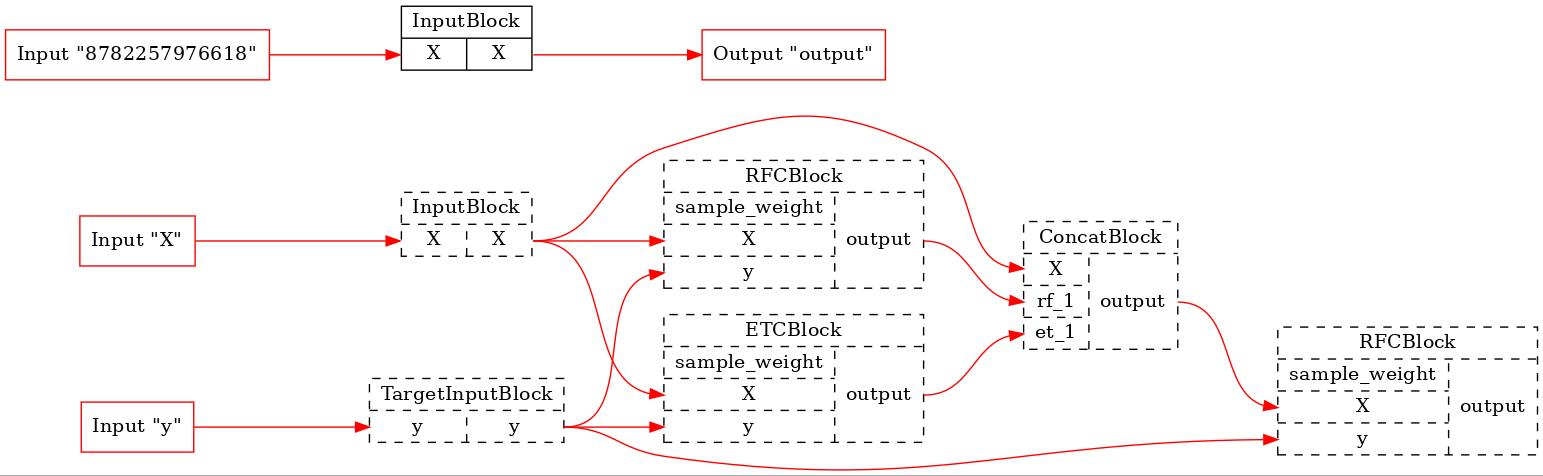

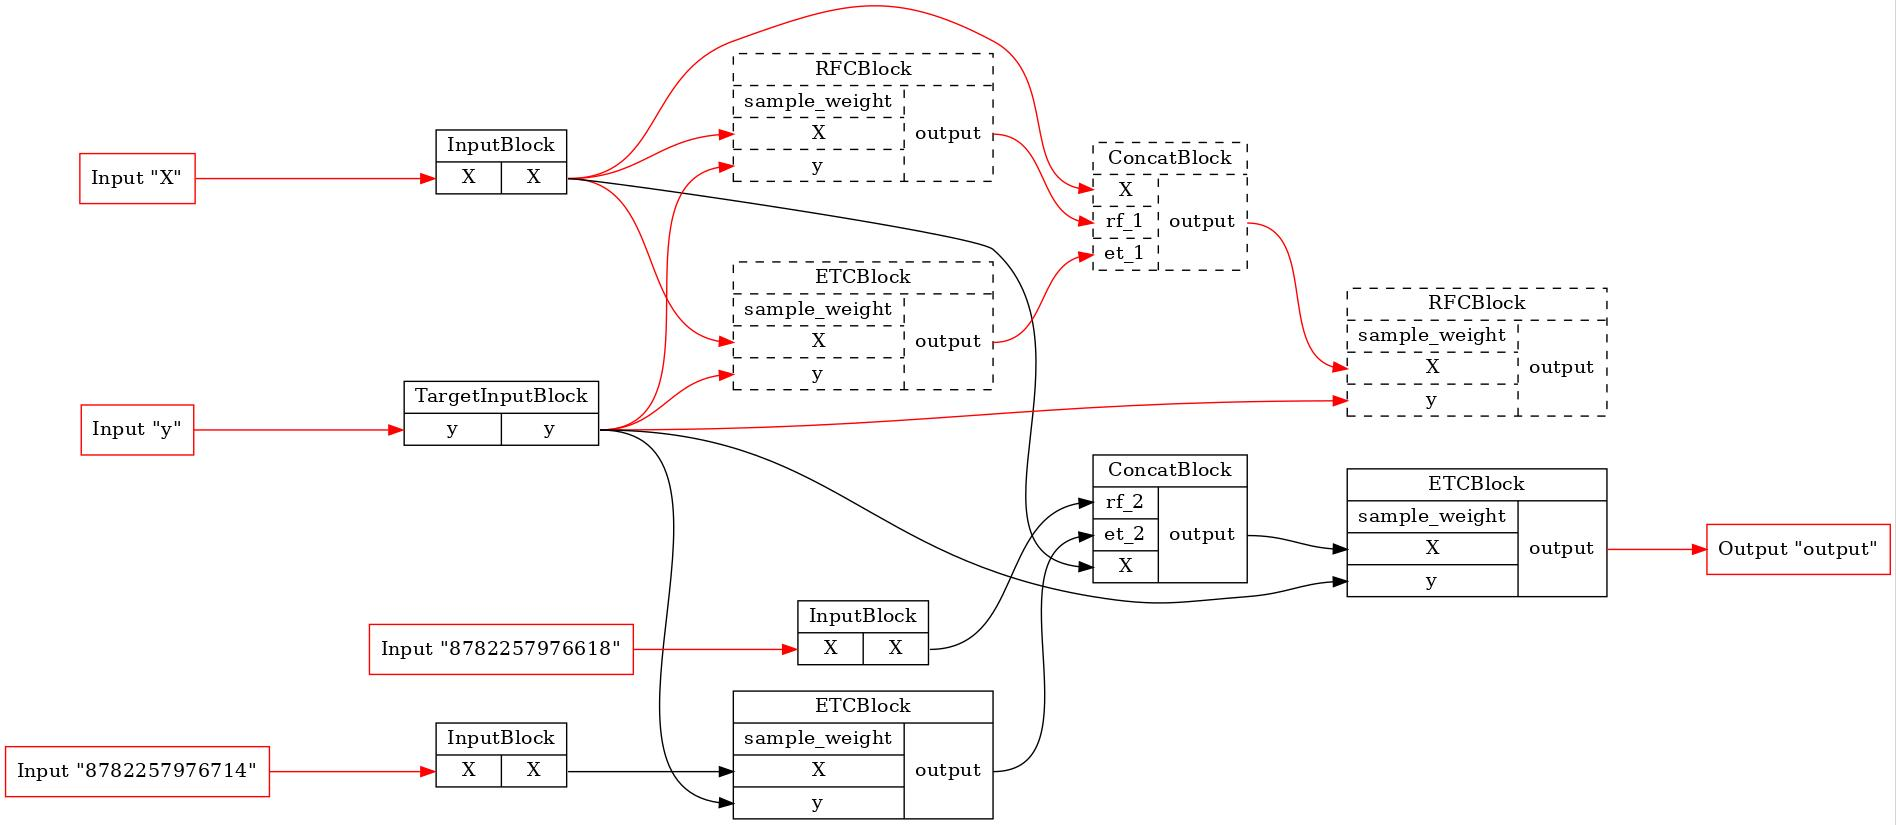

In [8]:
for pip in comparator._optim_pipelines[0::2]:
    executor = TopologicalExecutor(pip, Stage.FIT)
    TopologicalPainter(figure_dpi=100).from_executor(executor).render('pipeline.jpeg')
    display(Image('pipeline.jpeg'))

As we can see, none of the original blocks will be executed in the first pipeline. In the last one a lot of blocks were excluded from the training process. So, `BaseComparator` founds the common part of the pipelines, cuts it out of them and inserts additional input plugs. It allows us run the common part only once and use its results in other pipelines.

Let's run the comparator and obtain the result table

In [9]:
# let's make some data
x, y = make_moons(200, noise=0.5, random_state=random_seed)
data = {'X': CPUData(x), 'y': CPUData(y)}
result = comparator.get_score(data, [
    MetricWrapper(accuracy, name='accuracy'),
    MetricWrapper(roc_auc, name='roc-auc')
])
result.head()

,model name,fold #,train/test,time,blocks time,accuracy,roc-auc
0,deep forest 0,0,train,0.070443,"{InputBlock: 4.89999999953028e-06, TargetInput...",0.992481,0.992857
1,deep forest 0,0,test,0.006083,"{InputBlock: 1.8999999999991246e-06, ETCBlock:...",0.776119,0.772072
2,deep forest 1,0,train,0.070605,"{StackBlock: 6.709999999987559e-05, AverageBlo...",0.992481,0.992857
3,deep forest 1,0,test,0.006156,"{StackBlock: 1.8800000000318562e-05, AverageBl...",0.776119,0.772072
4,deep forest 2,0,train,0.100048,"{TargetInputBlock: 1.4000000003733248e-06, ETC...",1.000000,1.000000


We've got Pandas Dataframe. Let's describe all the columns:
- `model name` - is the name of the compared model. In case of the bosk pipeline it will be marked as `deep forest i`, foreign models are named `model i`. Models are ordered as they were passed in the initializing list.
- `fold #` - number of the fold starting with 0.
- `train/test` - string binary label if it is a train or test result.
- `time` - CPU time of the fold proceeding.
- `blocks time` - optional column if the `get_blocks_times` initialization flag was set to the True. This is the only column containing non-scalar data. The cells contain dictionaries with the pipeline's blocks as keys and their CPU execution time as values.
- `metric_name` columns - value of the corresponding metric on this fold. If the metric name wasn't provided, column would be named as `metric_i`, where `i` is the position in the initializing list.